In [1]:
from stellargraph.data import EdgeSplitter
import numpy as np
from sklearn.model_selection import train_test_split
import multiprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score

import stellargraph as sg
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objs as go
from plotly.offline import plot
from sklearn.metrics import confusion_matrix

used_params = {
    'p': 1.0,
    'q': 0.6,
    'dimensions': 128,
    'num_walks': 100,
    'walk_length': 30,
    'window_size': 13,
    'num_iter': 5,
    'workers': multiprocessing.cpu_count()
}

def create_mapping(file_content):
    # Convert the uploaded file content to a string
    text = file_content.decode('utf-8')

    # Feldolgozom a sorokat
    connections = []
    from_list = []
    to_list = []
    for row in text.split('\n')[:-1]:
        a, b = [int(x) for x in row.split(' ')]
        connections.append((a, b))

        from_list.append(a)
        to_list.append(b)

    id_mapper = {}
    reverse_id_mapper = {}
    counter = 0
    for elem in from_list:
        if elem not in id_mapper.values():
            id_mapper[counter] = elem
            reverse_id_mapper[elem] = counter
            counter += 1

    for elem in to_list:
        if elem not in id_mapper.values():
            id_mapper[counter] = elem
            reverse_id_mapper[elem] = counter
            counter += 1

    scaled_connections = []
    for first, second in connections:
        first_scaled = reverse_id_mapper[first]
        second_scaled = reverse_id_mapper[second]

        scaled_connections.append((first_scaled, second_scaled))

    return scaled_connections, id_mapper, reverse_id_mapper

def create_graph(connections):
    graph = nx.Graph()
    graph.add_edges_from(connections)
    graph = sg.StellarGraph.from_networkx(graph)

    return graph

def node2vec_embedding(graph, name):
    rw = BiasedRandomWalk(graph)
    walks = rw.run(graph.nodes(), n=used_params['num_walks'], length=used_params['walk_length'], p=used_params['p'], q=used_params['q'])
    print(f"Number of random walks for '{name}': {len(walks)}")

    model = Word2Vec(
        walks,
        vector_size=used_params['dimensions'],
        window=used_params['window_size'],
        min_count=0,
        sg=1,
        workers=used_params['workers'],
        epochs=used_params['num_iter'],
    )

    def get_embedding(u):
        return model.wv[u]

    return get_embedding

def operator_l2(u, v):
    return (u - v) ** 2


def link_prediction_classifier(max_iter=4000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])

def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples]

def train_link_prediction_model(
        link_examples, link_labels, get_embedding, binary_operator
):
    # Ezt akár lehet módosítani is más algoritmussal
    clf = link_prediction_classifier()

    # Itt távolságot számol a start és end pont embeddingje között
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    # Majd arra fitteli a modelt
    clf.fit(link_features, link_labels)
    return clf

def create_result_df(graph, model, embedding, operator):
    nodes = list(graph.nodes())
    nodes.sort()

    first_node = []
    second_node = []
    for node1 in nodes:
        for node2 in nodes:
            if node1 < node2:
                first_node.append(node1)
                second_node.append(node2)


    prob_df = pd.DataFrame({'first_node': first_node, 'second_node': second_node})
    processed_tmp = link_examples_to_features(prob_df.values, embedding, operator)

    prob_df['prob'] = model.predict_proba(processed_tmp)[:,1]
    prob_df['pred_class'] = model.predict(processed_tmp)

    prob_df = prob_df.set_index(['first_node', 'second_node'])

    graph_edges = [(min(u, v), max(u, v)) for u, v in G.edges()]
    graph_df = pd.DataFrame(graph_edges, columns=['first_node', 'second_node'])

    graph_df = graph_df.set_index(['first_node', 'second_node'])

    graph_df['edge'] = 1

    result_df = prob_df.join(graph_df, how = 'left')
    result_df['edge'] = result_df['edge'].fillna(0)
    result_df['pred_edge'] = result_df['prob'].apply(lambda x: 1 if x > 0.5 else 0)


    return result_df

def plot_confusion_matrix(df, real, predicted):
    cm = confusion_matrix(df[real], df[predicted])

    class_labels = ['Negative Edge', 'Edge']

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    plt.show()


def plot_roc_curve(predictions_df):
    # Extract the 'Real', 'Pred', and 'Prob' columns
    ground_truth_values = predictions_df['edge'].tolist()
    predictions = predictions_df['pred_edge'].tolist()

    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(ground_truth_values, predictions)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = roc_auc_score(ground_truth_values, predictions)

    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

def plot_histogram(df):
    plt.figure(figsize=(10, 6))  # Set the figure size
    plt.hist(df.prob, bins=30, color='skyblue', edgecolor='black', alpha=0.7)  # Customize histogram appearance
    plt.title('Probability Distribution Histogram')  # Set the title
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid lines
    plt.show()

def read_graph_a(path, map = True):
    id_mapper_ = None
    reverse_id_mapper_ = None

    if map:
        id_mapper_, reverse_id_mapper_, edges = create_mapping_a(path)
        G_ = nx.Graph()
        G_.add_edges_from(edges)
    else:
        G_ = nx.read_edgelist(path, nodetype=int, create_using=nx.Graph())

    G_ = sg.StellarGraph.from_networkx(G_)

    return G_, id_mapper_, reverse_id_mapper_

def create_mapping_a(path):
    with open(path, 'rt') as file:
        text = file.read()

    # Feldolgozom a sorokat
    connections = []
    from_list = []
    to_list = []
    for row in text.split('\n')[:-1]:
        a, b = [int(x) for x in row.split(' ')]
        connections.append((a, b))

        from_list.append(a)
        to_list.append(b)


    id_mapper = {}
    reverse_id_mapper = {}
    counter = 0
    for elem in from_list:
        if elem not in id_mapper.values():
            id_mapper[counter] = elem
            reverse_id_mapper[elem] = counter
            counter += 1

    for elem in to_list:
        if elem not in id_mapper.values():
            id_mapper[counter] = elem
            reverse_id_mapper[elem] = counter
            counter += 1

    scaled_connections = []
    for first, second in connections:
        first_scaled = reverse_id_mapper[first]
        second_scaled = reverse_id_mapper[second]

        scaled_connections.append((first_scaled, second_scaled))

    return id_mapper, reverse_id_mapper, scaled_connections



# mapper, reverse_mapper, graph_edges = create_mapping(file)
G, mapper, reverse_mapper = read_graph_a('facebook/0.edges')
# G = create_graph(G_)

edge_splitter = EdgeSplitter(G)
splitted_graph, X, y = edge_splitter.train_test_split(p=0.2, method="global")

embedding_all = node2vec_embedding(splitted_graph, "Graph") # TODO: Megkérdezni valaki, hogy G-vel miért nem működik, nem értem

model = train_link_prediction_model(X, y, embedding_all, operator_l2)

predictions = create_result_df(splitted_graph, model, embedding_all, operator_l2)

** Sampled 503 positive and 503 negative edges. **
Number of random walks for 'Graph': 33300


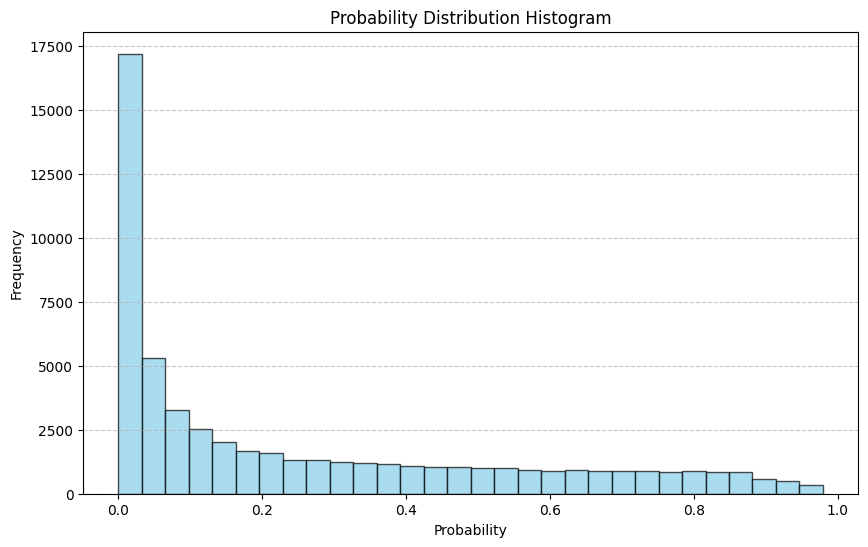

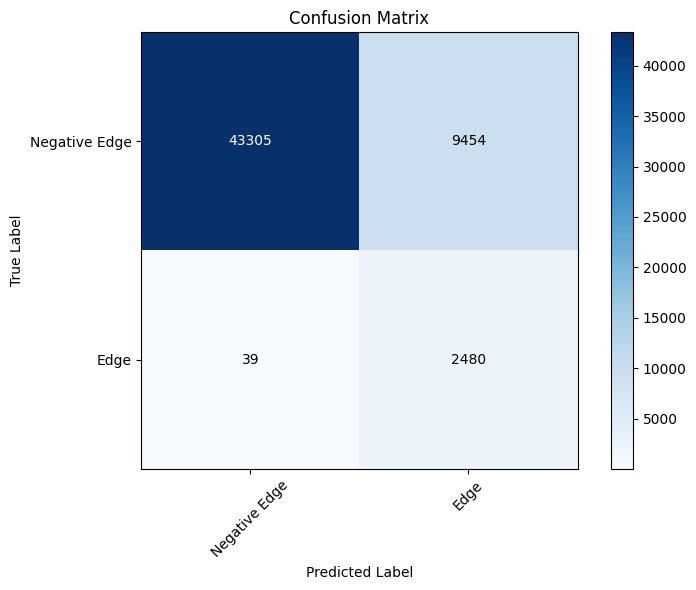

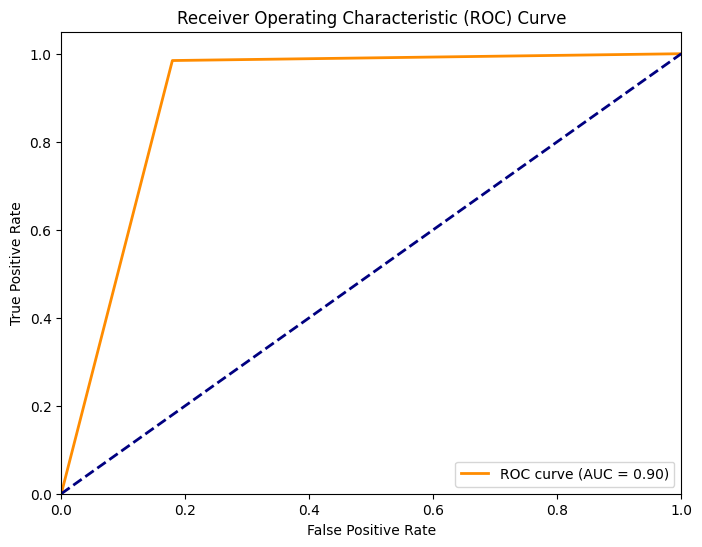

In [2]:
plot_histogram(predictions)
plot_confusion_matrix(predictions, 'edge', 'pred_edge')
plot_roc_curve(predictions)

In [3]:
nx_G = G.to_networkx()

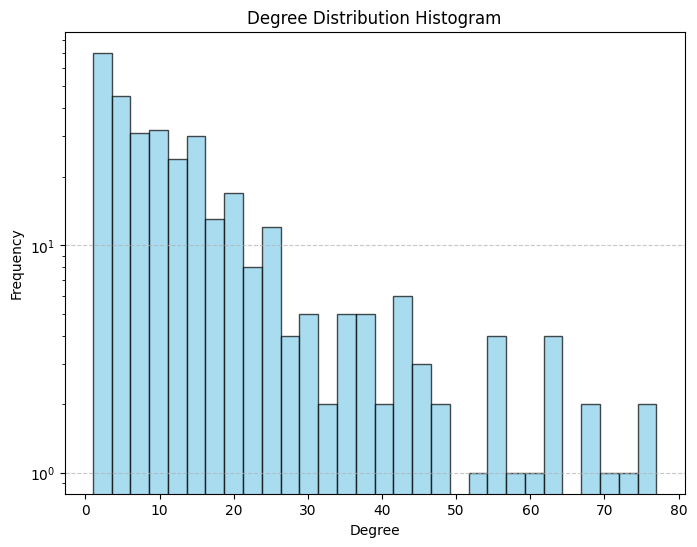

In [4]:
def plot_degree_distribution_log(G):
    degree_dict = dict(G.degree())
    degree = list(degree_dict.values())

    plt.figure(figsize=(8, 6))
    plt.hist(degree, bins=30, color='skyblue', edgecolor='black', alpha=0.7, log=True)
    plt.title('Degree Distribution Histogram')
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_degree_distribution_log(nx_G)

c:\users\geako\dataspellprojects\friend_venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\users\geako\dataspellprojects\friend_venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

c:\users\geako\dataspellprojects\friend_venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Best threshold: 0.81, Best F1: 0.5714285714285715


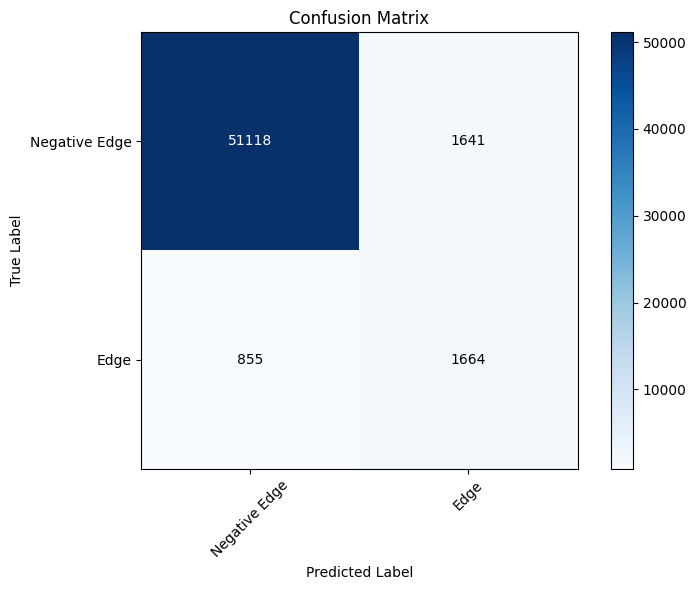

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_recall(df):
    return recall_score(df['edge'], df['pred_edge'])

def calculate_precision(df):
    return precision_score(df['edge'], df['pred_edge'])

def calculate_f1(df):
    return f1_score(df['edge'], df['pred_edge'])

def calculate_accuracy(df):
    return accuracy_score(df['edge'], df['pred_edge'])

def calculate_metrics(df):
    recall = calculate_recall(df)
    precision = calculate_precision(df)
    f1 = calculate_f1(df)
    accuracy = calculate_accuracy(df)

    return recall, precision, f1, accuracy

def calculate_metrics_for_threshold(df, threshold):
    df['pred_edge'] = df['prob'].apply(lambda x: 1 if x > threshold else 0)

    return calculate_metrics(df)

def find_best_threshold(df):
    thresholds = np.linspace(0.01, 1, 100)
    best_threshold = 0
    best_f1 = 0
    for threshold in thresholds:
        recall, precision, f1, accuracy = calculate_metrics_for_threshold(df, threshold)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

# recall, precison, f1, accuracy = calculate_metrics(predictions)
best_threshold, best_f1 = find_best_threshold(predictions)
print(f'Best threshold: {best_threshold}, Best F1: {best_f1}')

def create_confusion_matrix(df, threshold):
    df['pred_edge'] = df['prob'].apply(lambda x: 1 if x > threshold else 0)

    return confusion_matrix(df['edge'], df['pred_edge'])

def plot_confusion_matrix(cm):
    class_labels = ['Negative Edge', 'Edge']

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    plt.tight_layout()
    plt.show()

cm = create_confusion_matrix(predictions, best_threshold)
plot_confusion_matrix(cm);

## Create Offers For Each User

In [6]:
predictions.head()

prob  pred_class  edge  pred_edge
first_node second_node                                       
0          1            0.847336           1   1.0          1
           2            0.434587           0   0.0          0
           3            0.890369           1   1.0          1
           4            0.740408           1   0.0          0
           5            0.607806           1   0.0          0

In [ ]:
offers = predictions[(predictions['edge'] == 0) & (predictions['pred_edge'] == 1)].reset_index()

In [9]:
result_dict = {node: None for node in G.nodes()}
recommendation_number = 5

for node in G.nodes():
    filtered_offers = offers[(offers['first_node'] == node) | (offers['second_node'] == node)].copy()

    filtered_offers['neighbor'] = filtered_offers.apply(lambda x: x['first_node'] if x['first_node'] != node else x['second_node'], axis = 1).astype('int')

    result_dict[node] = list(filtered_offers.sort_values('prob', ascending = False)['neighbor'][:recommendation_number])

In [10]:
result_dict

{0: [65, 107, 31, 71, 23],
 56: [86, 59, 35, 115, 11],
 1: [31, 134, 137, 106, 11],
 22: [247, 136, 101, 134, 109],
 2: [19, 129, 139, 6, 102],
 80: [28],
 3: [136, 45, 193, 138, 328],
 115: [86, 134, 56, 44, 30],
 4: [60, 10, 65, 95, 44],
 107: [65, 14, 137, 0, 289],
 5: [183, 129],
 131: [214],
 6: [2, 208, 183, 28],
 47: [91],
 7: [69, 11, 140, 71, 196],
 84: [15, 56, 171, 86, 23],
 8: [86, 40, 136, 56, 36],
 223: [],
 9: [301, 117, 10, 90, 23],
 36: [70, 11, 122, 328, 196],
 10: [137, 34, 117, 31, 171],
 95: [44, 171, 36, 4, 137],
 11: [36, 60, 44, 7, 29],
 31: [18, 44, 23, 10, 301],
 12: [],
 13: [65, 14, 60, 117, 29],
 45: [3, 107, 136, 69, 109],
 14: [107, 86, 57, 138, 77],
 78: [60, 107, 109, 44, 56],
 15: [65, 84, 89, 136, 140],
 32: [208],
 16: [65, 301, 89, 4, 34],
 18: [31, 137, 89, 301, 193],
 17: [231, 281],
 188: [229, 217, 230, 179, 322],
 34: [10, 328, 196, 93, 269],
 19: [2, 88, 124],
 132: [129, 124, 28, 102],
 20: [36, 60, 44, 29, 196],
 181: [],
 21: [124],
 39: [1

In [11]:
chosen_node = 2

# Get the recommended nodes for the chosen node
recommendations = result_dict[chosen_node]

# Get the neighbors of the chosen node
neighbors = list(G.neighbors(chosen_node))

# Ez a rész nem kell, ezért kinullázom
recommendation_neighbors = []
for node in recommendations:
    t = list(G.neighbors(node))
    recommendation_neighbors += t

recommendation_neighbors = []

# Create a set of nodes in the subgraph
subgraph_nodes = set(recommendation_neighbors + recommendations + neighbors + [chosen_node])

# Create a subgraph from the set of nodes
subgraph = G.subgraph(list(subgraph_nodes)).to_networkx()

new_edges = [(chosen_node, recommendation) for recommendation in recommendations]

subgraph.add_edges_from(new_edges)

# Compute positions for the entire subgraph
pos = nx.spring_layout(subgraph)

# Define colors for nodes
node_colors = {
    **{n: 'green' for n in neighbors},           # Neighbor nodes color
    **{n: 'blue' for n in recommendation_neighbors},  # Neighbors of neighbors color
    **{n: 'yellow' for n in recommendations},   # Recommended nodes color
    chosen_node: 'red'            # Chosen node color
}

# Create nodes and edges for plotly
edge_trace_yellow = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='yellow'),  # Specify the edge color as yellow
    hoverinfo='none',
    mode='lines')

edge_trace_blue = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='green'),  # Specify the edge color as yellow
    hoverinfo='none',
    mode='lines')


edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        size=10,
        colorbar=dict(
            thickness=15,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=2)))

for edge in subgraph.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])


    if (edge[0] == chosen_node) and (edge[1] in recommendations) or (edge[1] == chosen_node) and (edge[0] in recommendations):
        edge_trace_yellow['x'] += tuple([x0, x1, None])  # Add to the yellow edge trace
        edge_trace_yellow['y'] += tuple([y0, y1, None])  # Add to the yellow edge trace

    elif (edge[0] == chosen_node) and (edge[1] in neighbors) or (edge[1] == chosen_node) and (edge[0] in neighbors):
        edge_trace_blue['x'] += tuple([x0, x1, None])  # Add to the yellow edge trace
        edge_trace_blue['y'] += tuple([y0, y1, None])  # Add to the yellow edge trace

    else:
        edge_trace['x'] += tuple([x0, x1, None])
        edge_trace['y'] += tuple([y0, y1, None])

for node in subgraph.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['text'] += tuple([f'Node: {node}'])

# Create the plotly figure with both edge traces
fig = go.Figure(
    data=[edge_trace_yellow, edge_trace_blue, edge_trace, node_trace],
    layout=go.Layout(
        showlegend=False,
        hovermode='closest',
        margin=dict(b=0, l=0, r=0, t=0),
    )
)

# Update the node colors
fig.update_traces(marker=dict(color=[node_colors[node] for node in subgraph.nodes()]))

# Show the interactive plot
plot(fig, filename='interactive_network.html')

print("Chosen Node:", chosen_node)
print('Neighbor Nodes:', neighbors)
print('Recommendation Nodes:', result_dict[chosen_node])

Chosen Node: 2
Neighbor Nodes: [214, 50, 124, 178, 132, 144, 167, 116, 183, 208, 88, 32, 119, 80, 219]
Recommendation Nodes: [19, 129, 139, 6, 102]


what i want:

choose a node
plot all connection between this node and all of its neighbors
plot all connection between this node and all of the recommended nodes
plot all connections between the neighbors between each other and the recommended nodes

plot chosen node, recommended node, neighbor node with different color